In [1]:
import os
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.ticker as tck
from matplotlib import colors

import numpy as np

from scipy.interpolate import interp1d

import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.constants as const

from astropy.cosmology import default_cosmology
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from astropy.io import fits
from astropy import constants as const
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from astropy.constants import G, c, M_sun
import astropy.io.fits as pyfits
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Util import kernel_util
import emcee
import corner
import dynesty
from dynesty import utils as dyfunc
import pickle
from dynesty import plotting as dyplot
import matplotlib

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
import pyswarms as ps
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
import warnings

warnings.filterwarnings('ignore')

import astropy.io.fits as pyfits
from astropy.io import fits
import matplotlib

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 50}
matplotlib.rc('font', **font)
warnings.filterwarnings('ignore')

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
likemask = np.ones([70,70],dtype=bool)

for i in range(70):
    for j in range(70):
        if (i-32)**2. + (j-34)**2. < 30:
            likemask[i,j] = False
        if (i-34)**2. + (j-34)**2. > 1300:
            likemask[i,j] = False
            
ndeg = np.count_nonzero(likemask)

imagedata = np.load('sersic_source_subtracted.npy')*likemask

source_res = 4

observe_kwargs = {'read_noise': 4.0,
                  'pixel_scale': 0.025, 
                  'ccd_gain': 2.5, 
                  'exposure_time': 6976., 
                  'sky_brightness': 22.3, 
                  'magnitude_zero_point': 25.96, 
                  'num_exposures': 1, 
                  'seeing': 0.07, 
                  'psf_type': 'PIXEL'}
hiresforsource = {'read_noise': 4.0, 
                  'pixel_scale': 0.025/source_res, 
                  'ccd_gain': 2.5, 
                  'exposure_time': 6976., 
                  'sky_brightness': 22.3, 
                  'magnitude_zero_point': 25.96, 
                  'num_exposures': 1, 
                  'seeing': 0.07, 
                  'psf_type': 'PIXEL'}

background_rms = 0.0042071166

exp_time = observe_kwargs['exposure_time']

z_interloper = 0.881
z_lens =  0.881
z_source =  2.059

numpix = 70
deltaPix = 0.025
ext = numpix*deltaPix/2.
extent = [-ext,ext,-ext,ext]

fwhm = 0.14

kernel_point = np.zeros([15,15])
kernel_point[7,7] = 1.

kernel_cut = np.zeros([15,15])

for i in range(15):
    for j in range(15):
        sigm = (1./2.355)*(fwhm/deltaPix)
        kernel_cut[i,j] = np.exp(-(0.5/sigm**2.)*((i-45)**2. + (j-45)**2.))

kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
kwargs_point = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_point}
psf_class = PSF(**kwargs_psf)
psf_point = PSF(**kwargs_point)

kwargs_numerics = {'point_source_supersampling_factor': 1}


#https://arxiv.org/pdf/1402.7073.pdf

def bfunc(z):
    return -0.101 + 0.026*z

def afunc(z):
    return 0.520 + (0.905 - 0.520)*np.exp(-0.617*(z**1.21))

def c200vsM200(M200,z):
    # This is in log10 units. Mass is h^-1 Msun
    return bfunc(z)*(M200-12) + afunc(z)

def nfw_from_M200(M200,z):
    # takes in logM200 in Msun
    # returns nfw params in arcsec
    lens_cosmo = LensCosmo(z_lens=z, z_source=z_source, cosmo=cosmo)
    Mh = M200 + np.log10(cosmo.h)
    concen = c200vsM200(Mh,z)
    
    Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=10**Mh, c=10**concen)
    
    return Rs_angle,alpha_Rs
    
def nfw_fromM200andC200(M200,c200,z):
    # takes in logM200 in Msun and c200
    # returns nfw params in arcsec
    lens_cosmo = LensCosmo(z_lens=z, z_source=z_source, cosmo=cosmo)
    Mh = M200 + np.log10(cosmo.h)
    
    Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=10**Mh, c=c200)
    
    return Rs_angle,alpha_Rs

def bestfit(result):
    #takes in the result, returns best fit and errors
    #and returns -logl
    logs = result.logl
    samps = result.samples
    argmax = np.argmax(logs)
    
    weights = np.exp(result.logwt - result.logz[-1])
    mean, cov = dyfunc.mean_and_cov(samps, weights)
    
    errs = [cov[i,i] for i in range(len(mean))]
    
    return logs[argmax],samps[argmax],np.sqrt(errs)*2.

def bic(logl,kparam):
    #takes in the logl and ndeg
    #and calculates the BIC
    return kparam*np.log(ndeg) - 2.*logl


def roundvalanderr(best,c0):
    #get best fit and cv and round
    logs = -np.log10(c0)
    rounded = np.zeros(len(best))
    roundederr = np.zeros(len(best))
    for i in range(len(best)):
        rounded[i] = round(best[i],1+int(round(logs[i])))
        roundederr[i] = round(c0[i],1+int(round(logs[i])))
    return rounded,roundederr

def printnice(best,c0):
    bestfround,cvround = roundvalanderr(best,c0)
    for i in range(len(bestfround)):
        print('%.3f + %.3f'% (best[i],c0[i]))
        
def getstats(reslist):
    ln = len(reslist)
    maxl = []
    bestf = []
    cv = []
    for i in range(ln):
        a,b,c = bestfit(reslist[i])
        maxl.append(a)
        bestf.append(b)
        cv.append(c)
    maxl = np.array(maxl)
    bestf = np.array(bestf)
    cv = np.array(cv)
    
    return maxl,bestf,cv 
        
def getbic(maxlist,nmodel):
    ln = len(maxlist)
    nmaxes = np.arange(ln) + 9
    
    bics = []
    
    for i in range(ln):
        kparam = (nmaxes[i]+1)*(nmaxes[i]+2)*0.5
        bicval = bic(maxlist[i],nmodel + kparam)
        bics.append(bicval)
    
    bics = np.array(bics)
    return bics  

def getbys(reslist):
    ln = len(reslist)
    bys = []
    for i in range(ln):
        by = np.max(reslist[i].logz)
        bys.append(by)
    bys = np.array(bys)
    return bys
        
labls_mask = ['$\\theta_E$','$\\gamma$', '$x_1$', '$x_2$','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
              'beta','sx','sy']

labls_mask_sub = ['$\\theta_E$','$\\gamma$', '$x_1$', '$x_2$','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                  '$b_\mathrm{int}$ [mas]','$x_\mathrm{int}$ [arcsec]','$y_\mathrm{int}$ [arcsec]',
                  'beta','sx','sy']

labls_mask_sub_nfw = ['$\\theta_E$','$\\gamma$', '$x_1$', '$x_2$','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                      'm200','x_int','y_int',
                      'beta','sx','sy']

labls_mask_sub_c = ['$\\theta_E$','$\\gamma$', '$x_1$', '$x_2$','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                    '$M_\mathrm{200}\, [10^{9}M_\odot]$','$x_\mathrm{int}$ [arcsec]','$y_\mathrm{int}$ [arcsec]','$c_{200}$',
                    'beta','sx','sy']

labls_mask_sub_s = ['$\\theta_E$','$\\gamma$', '$x_1$', '$x_2$','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                    'theta_e','x_int','y_int','slope',
                     'beta','sx','sy']

labls_mask_int = ['$\\theta_E$','$\\gamma$', '$x_1$', '$x_2$','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                  '$b_\mathrm{int}$ [mas]','$x_\mathrm{int}$ [arcsec]','$y_\mathrm{int}$ [arcsec]','$z_\mathrm{int}$',
                  'beta','sx','sy']

labls_mask_int_nfw = ['$\\theta_E$','$\\gamma$', '$x_1$', '$x_2$','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                      '$M_\mathrm{200}\, [10^{9}M_\odot]$','$x_\mathrm{int}$ [arcsec]','$y_\mathrm{int}$ [arcsec]','$z_\mathrm{int}$',
                      'beta','sx','sy']

labls_mask_int_c = ['$\\theta_E$','$\\gamma$', '$x_1$', '$x_2$','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                    '$M_\mathrm{200}\, [10^{9}M_\odot]$','$x_\mathrm{int}$ [arcsec]','$y_\mathrm{int}$ [arcsec]','$z_\mathrm{int}$','$c_{200}$',
                    'beta','sx','sy']

labls_mask_int_s = ['$\\theta_E$','$\\gamma$', '$x_1$', '$x_2$','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                    'theta_e','x_int','y_int','z_int','slope',
                    'beta','sx','sy']

In [2]:
def model_shape2(data0,main_lens,shear,subhalo,beta_model,source_x,source_y,n_max_model,Mtype,Itype):
    lens_model_list = ['PEMD','SHEAR',Itype]

    kwargs_model_shape = {'lens_model_list': ['PEMD','SHEAR',Itype],  # list of lens models to be used
                          'lens_light_model_list': [],  # list of unlensed light models to be used
                          'source_light_model_list': ['SHAPELETS_POLAR'],  # list of extended source models to be used
                          'z_lens': z_lens, 'z_source': z_source,}
    kwargs_model_source = {'lens_model_list': ['PEMD','SHEAR',Itype],  # list of lens models to be used
                          'lens_light_model_list': [],  # list of unlensed light models to be used
                          'source_light_model_list': ['SHAPELETS_POLAR'],  # list of extended source models to be used
                          'z_lens': z_lens, 'z_source': z_source,}

    simhst_shape = SimAPI(numpix=numpix, kwargs_single_band=observe_kwargs, kwargs_model=kwargs_model_shape)
    simhst_source = SimAPI(numpix=source_res *numpix, kwargs_single_band=hiresforsource, kwargs_model=kwargs_model_source)

    kwargs_data_real = sim_util.data_configure_simple(numpix, deltaPix, exp_time, background_rms)
    data_real = ImageData(**kwargs_data_real)

    data_real.update_data(data0)
    psf = psf_point
        
    theta_E,gamma,clx,cly,el1,el2 = main_lens
    gamma1, gamma2 = shear
    
    ra = 1e-4

    if Mtype == 'SMOOTH':
        centerxproj, centeryproj,z_int = 0.,0.,z_lens
        if Itype == 'SIS' or Itype == 'PJAFFE':
            theta_e = 0.
            rs = np.sqrt(theta_e*2e-3*theta_E)
            sig_0 = (theta_e*2e-3*(rs-ra))/(2.*ra*rs)
        else:
            rs, alrs = 1.,0.
    if Mtype == 'SUB':
        z_int = z_lens
        if Itype == 'SIS':
            theta_e, centerxproj, centeryproj = subhalo
        elif Itype == 'PJAFFE':
            theta_e, centerxproj, centeryproj = subhalo
            rs = np.sqrt(theta_e*2e-3*theta_E)
            sig_0 = (theta_e*2e-3*(rs-ra))/(2.*ra*rs)
        else:
            M, centerxproj, centeryproj = subhalo
            logM = np.log10(M*(10.**10.))
            rs, alrs = nfw_from_M200(logM,z_int)
            
    if Mtype == 'SUBc':
        z_int = z_lens
        M, centerxproj, centeryproj,c200 = subhalo
        logM = np.log10(M*(10.**10.))
        rs, alrs = nfw_fromM200andC200(logM,c200,z_int)
    
    if Mtype =='INT':
        if Itype == 'SIS':
            theta_e, centerxproj, centeryproj, z_int = subhalo
        elif Itype == 'PJAFFE':
            theta_e, centerxproj, centeryproj, z_int = subhalo
            rs = np.sqrt(theta_e*2e-3*theta_E)
            sig_0 = (theta_e*2e-3*(rs-ra))/(2.*ra*rs)
        else:
            M, centerxproj, centeryproj,z_int = subhalo
            logM = np.log10(M*(10.**10.))
            rs, alrs = nfw_from_M200(logM,z_int)
            
    if Mtype =='INTc':
        M, centerxproj, centeryproj,z_int,c200 = subhalo
        logM = np.log10(M*(10.**10.))
        rs, alrs = nfw_fromM200andC200(logM,c200,z_int)
    
    ######################Calculating Projectionn

    if z_int <= z_lens:
        centerx,centery = centerxproj,centeryproj
    else:
        kwargs_lens_model_macro = [{'theta_E': theta_E,'gamma':gamma, 'center_x': clx, 'center_y': cly, 'e1': el1, 'e2': el2},
                             {'gamma1': gamma1, 'gamma2': gamma2}]

        lens_model_list_macro = ['PEMD','SHEAR']
        redshifts_macro = [z_lens,z_lens]

        lens_model_class_macro = LensModel(lens_model_list=lens_model_list_macro, z_source=z_source, 
                                 lens_redshift_list=redshifts_macro, multi_plane=True)
        sourceplanex,sourceplaney = lens_model_class_macro.ray_shooting(centerxproj, centeryproj, kwargs_lens_model_macro, k=None)
            
        alpha_l = np.array([centerxproj,centeryproj])
        alpha_s = np.array([sourceplanex,sourceplaney])
        chis, chil, chi = cosmo.comoving_distance([z_source,z_lens,z_int])
            
        veca = (chis*alpha_s - chil*alpha_l)/(chis-chil)
        vecb = (alpha_l-alpha_s)*((chis*chil)/(chis-chil))
            
        centercood = veca + (1./chi)*vecb
        centerx,centery = float(centercood[0]),float(centercood[1])
         
    ###############################################
    
    if Itype == 'SIS':
        kw_int = {'theta_E':theta_e*2e-3, 'center_x':centerx, 'center_y':centery}
    elif Itype == 'PJAFFE':
        kw_int = {'Ra': ra, 'Rs': rs, 'center_x': centerx, 'center_y': centery, 'sigma0': sig_0}
    else:
        kw_int = {'Rs':rs, 'alpha_Rs':alrs, 'center_x':centerx, 'center_y':centery}    
        
    kwargs_lens_model = [{'theta_E': theta_E,'gamma':gamma, 'center_x': clx, 'center_y': cly, 'e1': el1, 'e2': el2},
                         {'gamma1': gamma1, 'gamma2': gamma2},
                         kw_int]
    redshifts_func = [z_lens,z_lens,z_int]
    
    lens_model_class_func = LensModel(lens_model_list=lens_model_list, z_source=z_source, 
                         lens_redshift_list=redshifts_func, multi_plane=True)


    sourceLightModel_reconstruct = LightModel(['SHAPELETS_POLAR'])
    lensLightModel_reconstruct = LightModel([])
    
    
    
    kwargs_shapelet = [{'n_max': n_max_model, 'beta': beta_model, 'center_x': source_x, 'center_y': source_y}]
    
    kwargs_lens_light2 = []
    
    imageModel = ImageLinearFit(data_class=data_real, psf_class=psf, kwargs_numerics=kwargs_numerics, 
                                lens_model_class=lens_model_class_func, source_model_class=sourceLightModel_reconstruct,
                                lens_light_model_class = lensLightModel_reconstruct,
                               likelihood_mask=likemask)
    
    wls_model, model_error, cov_param, coeffsq = imageModel.image_linear_solve(kwargs_lens_model, kwargs_shapelet, 
                                                                   kwargs_lens_light=kwargs_lens_light2, kwargs_ps=None, inv_bool=False)
    
    kwargs_shapelet_result = {'amp':coeffsq,'n_max': n_max_model, 'beta': beta_model, 'center_x': source_x, 'center_y': source_y}


    sourcelight = [kwargs_shapelet_result]
    lenslight = []
    
    imSim_HST_func = ImageModel(simhst_shape.data_class, psf, lens_model_class_func, simhst_shape.source_model_class,
                          simhst_shape.lens_light_model_class, simhst_shape.point_source_model_class, kwargs_numerics=kwargs_numerics)
    im2model = imSim_HST_func.image(kwargs_lens_model, sourcelight, lenslight)
        
    return im2model,coeffsq

In [3]:
def assignparam(data,params,n_max,mtype,itype):
    if mtype == 'SMOOTH':
        main_lens = params[0],params[1],params[2],params[3],params[4],params[5]
        shear = params[6],params[7]
        subhalo = params[0],params[1],params[2],params[3]       
        betaval,sx,sy = params[8],params[9],params[10]
                
    if mtype == 'SUB':
        main_lens = params[0],params[1],params[2],params[3],params[4],params[5]
        shear = params[6],params[7]
        subhalo = params[8],params[9],params[10]      
        betaval,sx,sy = params[11],params[12],params[13]
            
    if mtype == 'SUBc':
        main_lens = params[0],params[1],params[2],params[3],params[4],params[5]
        shear = params[6],params[7]
        subhalo = params[8],params[9],params[10],params[11]      
        betaval,sx,sy = params[12],params[13],params[14]

    if mtype == 'INT':
        main_lens = params[0],params[1],params[2],params[3],params[4],params[5]
        shear = params[6],params[7]
        subhalo = params[8],params[9],params[10],params[11]       
        betaval,sx,sy = params[12],params[13],params[14]
            
    if mtype == 'INTc':
        main_lens = params[0],params[1],params[2],params[3],params[4],params[5]
        shear = params[6],params[7]
        subhalo = params[8],params[9],params[10],params[11],params[12]    
        betaval,sx,sy = params[13],params[14],params[15]

    model1,coefv = model_shape2(data,main_lens,shear,subhalo,betaval,sx,sy,n_max,mtype,itype)
    return model1,coefv

In [4]:
name0 = 'results/wideprior/mask3013_on_jvas_70pixSUBTR_n_max'
name1 = 'results/narrowprior/mask3013_NARROW_on_jvas_70pixSUBTR_n_max'
name2 = 'results/freeconcen/oldprior/mask3013_NARROWCONCEN_on_jvas_70pixSUBTR_n_max'

sm = 'SMOOTH'
sb = 'SUB'
sbc = 'SUBc'
it = 'INT'
itc = 'INTc'

s = 'SIS'
j = 'PJAFFE'
n = 'NFW'


sub10 = load_obj(name1 + str(10) + sb + s)
submaxl, subbest, subcv = getstats([sub10])


int10 = load_obj(name0 + str(10) + it + s)
intmaxl, intbest, intcv = getstats([int10])


intj10 = load_obj(name0 + str(10) + it + j)
intjmaxl, intjbest, intjcv = getstats([intj10])

intc10 = load_obj(name2 + str(10) + itc + n)
intcmaxl, intcbest, intccv = getstats([intc10])

In [5]:
mod,cf= assignparam(imagedata,intbest[0],10,'INT','SIS')
mod2,cf2= assignparam(imagedata,intjbest[0],10,'INT','PJAFFE')
mod3,cf3= assignparam(imagedata,intcbest[0],10,'INTc','NFW')

In [6]:
def model_shape0(data0,main_lens,shear,subhalo,beta_model,source_x,source_y,n_max_model,Mtype,Itype,coeffs):
    lens_model_list = ['PEMD','SHEAR',Itype]

    kwargs_model_shape = {'lens_model_list': ['PEMD','SHEAR',Itype],  # list of lens models to be used
                          'lens_light_model_list': [],  # list of unlensed light models to be used
                          'source_light_model_list': ['SHAPELETS_POLAR'],  # list of extended source models to be used
                          'z_lens': z_lens, 'z_source': z_source,}
    kwargs_model_source = {'lens_model_list': ['PEMD','SHEAR',Itype],  # list of lens models to be used
                          'lens_light_model_list': [],  # list of unlensed light models to be used
                          'source_light_model_list': ['SHAPELETS_POLAR'],  # list of extended source models to be used
                          'z_lens': z_lens, 'z_source': z_source,}

    simhst_shape = SimAPI(numpix=numpix, kwargs_single_band=observe_kwargs, kwargs_model=kwargs_model_shape)
    simhst_source = SimAPI(numpix=source_res *numpix, kwargs_single_band=hiresforsource, kwargs_model=kwargs_model_source)

    kwargs_data_real = sim_util.data_configure_simple(numpix, deltaPix, exp_time, background_rms)
    data_real = ImageData(**kwargs_data_real)

    data_real.update_data(data0)
    psf = psf_point
        
    theta_E,gamma,clx,cly,el1,el2 = main_lens
    gamma1, gamma2 = shear
    
    ra = 1e-4

    if Mtype == 'SMOOTH':
        centerxproj, centeryproj,z_int = 0.,0.,z_lens
        if Itype == 'SIS' or Itype == 'PJAFFE':
            theta_e = 0.
            rs = np.sqrt(theta_e*2e-3*theta_E)
            sig_0 = (theta_e*2e-3*(rs-ra))/(2.*ra*rs)
        else:
            rs, alrs = 1.,0.
    if Mtype == 'SUB':
        z_int = z_lens
        if Itype == 'SIS':
            theta_e, centerxproj, centeryproj = subhalo
        elif Itype == 'PJAFFE':
            theta_e, centerxproj, centeryproj = subhalo
            rs = np.sqrt(theta_e*2e-3*theta_E)
            sig_0 = (theta_e*2e-3*(rs-ra))/(2.*ra*rs)
        else:
            M, centerxproj, centeryproj = subhalo
            logM = np.log10(M*(10.**10.))
            rs, alrs = nfw_from_M200(logM,z_int)
            
    if Mtype == 'SUBc':
        z_int = z_lens
        M, centerxproj, centeryproj,c200 = subhalo
        logM = np.log10(M*(10.**10.))
        rs, alrs = nfw_fromM200andC200(logM,c200,z_int)
    
    if Mtype =='INT':
        if Itype == 'SIS':
            theta_e, centerxproj, centeryproj, z_int = subhalo
        elif Itype == 'PJAFFE':
            theta_e, centerxproj, centeryproj, z_int = subhalo
            rs = np.sqrt(theta_e*2e-3*theta_E)
            sig_0 = (theta_e*2e-3*(rs-ra))/(2.*ra*rs)
        else:
            M, centerxproj, centeryproj,z_int = subhalo
            logM = np.log10(M*(10.**10.))
            rs, alrs = nfw_from_M200(logM,z_int)
            
    if Mtype =='INTc':
        M, centerxproj, centeryproj,z_int,c200 = subhalo
        logM = np.log10(M*(10.**10.))
        rs, alrs = nfw_fromM200andC200(logM,c200,z_int)
    
    ######################Calculating Projectionn

    if z_int <= z_lens:
        centerx,centery = centerxproj,centeryproj
    else:
        kwargs_lens_model_macro = [{'theta_E': theta_E,'gamma':gamma, 'center_x': clx, 'center_y': cly, 'e1': el1, 'e2': el2},
                             {'gamma1': gamma1, 'gamma2': gamma2}]

        lens_model_list_macro = ['PEMD','SHEAR']
        redshifts_macro = [z_lens,z_lens]

        lens_model_class_macro = LensModel(lens_model_list=lens_model_list_macro, z_source=z_source, 
                                 lens_redshift_list=redshifts_macro, multi_plane=True)
        sourceplanex,sourceplaney = lens_model_class_macro.ray_shooting(centerxproj, centeryproj, kwargs_lens_model_macro, k=None)
            
        alpha_l = np.array([centerxproj,centeryproj])
        alpha_s = np.array([sourceplanex,sourceplaney])
        chis, chil, chi = cosmo.comoving_distance([z_source,z_lens,z_int])
            
        veca = (chis*alpha_s - chil*alpha_l)/(chis-chil)
        vecb = (alpha_l-alpha_s)*((chis*chil)/(chis-chil))
            
        centercood = veca + (1./chi)*vecb
        centerx,centery = float(centercood[0]),float(centercood[1])
         
    ###############################################
    
    if Itype == 'SIS':
        kw_int = {'theta_E':theta_e*2e-3, 'center_x':centerx, 'center_y':centery}
    elif Itype == 'PJAFFE':
        kw_int = {'Ra': ra, 'Rs': rs, 'center_x': centerx, 'center_y': centery, 'sigma0': sig_0}
    else:
        kw_int = {'Rs':rs, 'alpha_Rs':alrs, 'center_x':centerx, 'center_y':centery}    
        
    kwargs_lens_model = [{'theta_E': theta_E,'gamma':gamma, 'center_x': clx, 'center_y': cly, 'e1': el1, 'e2': el2},
                         {'gamma1': gamma1, 'gamma2': gamma2},
                         kw_int]
    redshifts_func = [z_lens,z_lens,z_int]
    
    lens_model_class_func = LensModel(lens_model_list=lens_model_list, z_source=z_source, 
                         lens_redshift_list=redshifts_func, multi_plane=True)
   
    kwargs_shapelet_result = {'amp':coeffs,'n_max': n_max_model, 'beta': beta_model, 'center_x': source_x, 'center_y': source_y}


    sourcelight = [kwargs_shapelet_result]
    lenslight = []
    
    imSim_HST_func = ImageModel(simhst_shape.data_class, psf, lens_model_class_func, simhst_shape.source_model_class,
                          simhst_shape.lens_light_model_class, simhst_shape.point_source_model_class, kwargs_numerics=kwargs_numerics)
    im2model = imSim_HST_func.image(kwargs_lens_model, sourcelight, lenslight)
        
    poisson = image_util.add_poisson(im2model, exp_time=exp_time)
    bkg = image_util.add_background(im2model, sigma_bkd=background_rms)
        
    return im2model,bkg#+poisson

In [7]:
def assignparam0(params,n_max,mtype,itype,coefq):
    if mtype == 'SMOOTH':
        main_lens = params[0],params[1],params[2],params[3],params[4],params[5]
        shear = params[6],params[7]
        subhalo = params[0],params[1],params[2],params[3]       
        betaval,sx,sy = params[8],params[9],params[10]
                
    if mtype == 'SUB':
        main_lens = params[0],params[1],params[2],params[3],params[4],params[5]
        shear = params[6],params[7]
        subhalo = params[8],params[9],params[10]      
        betaval,sx,sy = params[11],params[12],params[13]
            
    if mtype == 'SUBc':
        main_lens = params[0],params[1],params[2],params[3],params[4],params[5]
        shear = params[6],params[7]
        subhalo = params[8],params[9],params[10],params[11]      
        betaval,sx,sy = params[12],params[13],params[14]

    if mtype == 'INT':
        main_lens = params[0],params[1],params[2],params[3],params[4],params[5]
        shear = params[6],params[7]
        subhalo = params[8],params[9],params[10],params[11]       
        betaval,sx,sy = params[12],params[13],params[14]
    if mtype == 'INTc':
        main_lens = params[0],params[1],params[2],params[3],params[4],params[5]
        shear = params[6],params[7]
        subhalo = params[8],params[9],params[10],params[11],params[12]    
        betaval,sx,sy = params[13],params[14],params[15]

    model1,bkg = model_shape0(imagedata*likemask,main_lens,shear,subhalo,betaval,sx,sy,n_max,mtype,itype,coefq)
    return model1,bkg

In [8]:
mod_mockpjaffe,bk_mock = assignparam0(intbest[0],10,'INT','SIS',cf)
mod_mocksis,bk_mock2 = assignparam0(intjbest[0],10,'INT','PJAFFE',cf2)
mod_mocknfw,bk_mock3  = assignparam0(intcbest[0],10,'INTc','NFW',cf3)

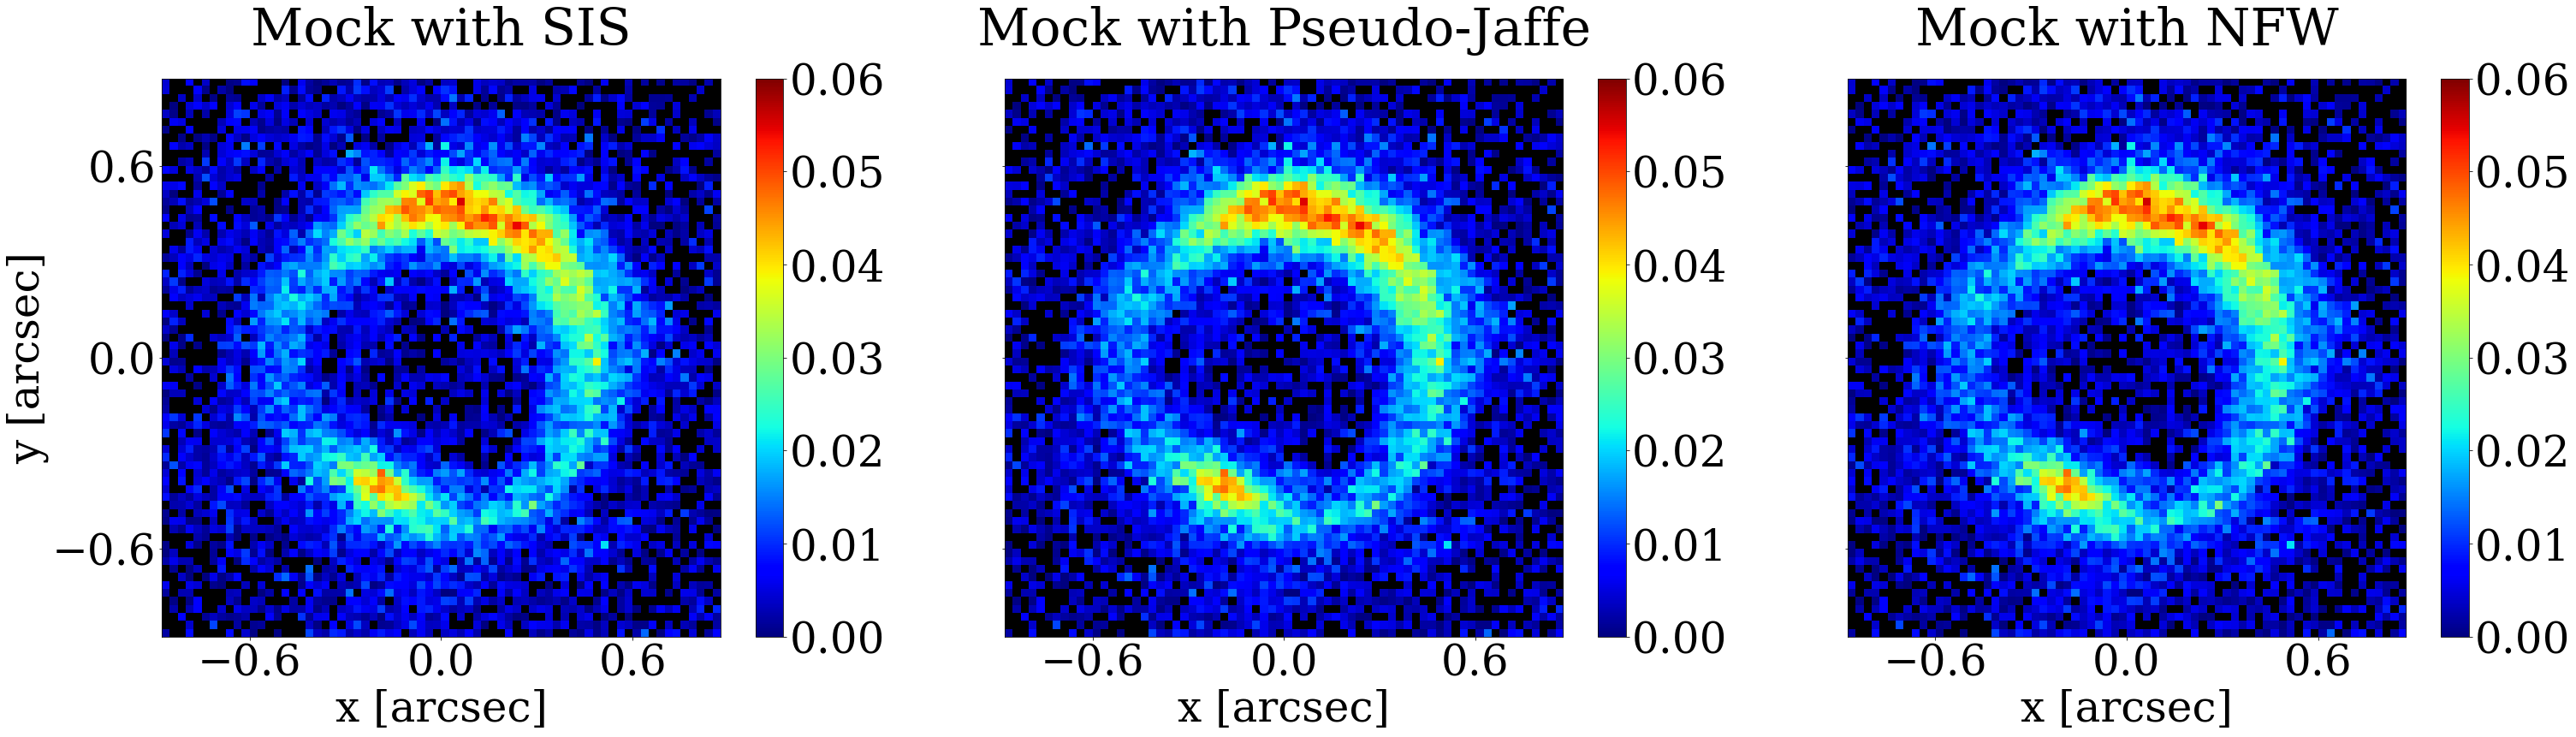

In [9]:
cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

# here we plot full image of the signal and the noise
M2 = 35

ext2 = M2*0.025
extent2 = [-ext2,ext2,-ext2,ext2]

f, axes = plt.subplots(1, 3, figsize=(50,12), sharex=False, sharey=True)
ax = axes


im0 = ax[0].matshow(mod_mocksis+bk_mock, origin='lower', vmin=0., vmax=0.06, cmap=cmap,extent=extent2)
ax[0].autoscale(False)
ax[0].set_title('Mock with SIS')
ax[0].xaxis.set_ticks_position('bottom')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(3))
ax[0].yaxis.set_major_locator(plt.MaxNLocator(3))
ax[0].set_xlabel('x [arcsec]')
ax[0].set_ylabel('y [arcsec]')
f.colorbar(im0, ax=axes[0])

im1 = ax[1].matshow(mod_mockpjaffe+bk_mock, origin='lower', vmin=0., vmax=0.06, cmap=cmap,extent=extent2)
ax[1].autoscale(False)
ax[1].set_title('Mock with Pseudo-Jaffe')
ax[1].xaxis.set_ticks_position('bottom')
ax[1].xaxis.set_major_locator(plt.MaxNLocator(3))
ax[1].yaxis.set_major_locator(plt.MaxNLocator(3))
ax[1].set_xlabel('x [arcsec]')
f.colorbar(im1, ax=axes[1])

im2 = ax[2].matshow(mod_mocknfw+bk_mock, origin='lower', vmin=0., vmax=0.06, cmap=cmap,extent=extent2)
ax[2].autoscale(False)
ax[2].set_title('Mock with NFW')
ax[2].xaxis.set_ticks_position('bottom')
ax[2].xaxis.set_major_locator(plt.MaxNLocator(3))
ax[2].yaxis.set_major_locator(plt.MaxNLocator(3))
ax[2].set_xlabel('x [arcsec]')
f.colorbar(im2, ax=axes[2])